In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('training.300000.processed.noemoticon.csv', encoding='latin-1')


In [6]:
print(df.head())
print(df.info())


   sentiment          id                          date     query  \
0          0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
1          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
2          0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
3          0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
4          0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

          username                                               text  
0  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
1      sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
2       sammydearr  @TiannaChaos i know  just family drama. its la...  
3      Lamb_Leanne  School email won't open  and I have geography ...  
4      yogicerdito                             upper airways problem   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ----

In [7]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
print(df.head())
print(df.info())

   sentiment          id                          date     query  \
0          0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
1          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
2          0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
3          0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
4          0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

          username                                               text  \
0  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!    
1      sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...   
2       sammydearr  @TiannaChaos i know  just family drama. its la...   
3      Lamb_Leanne  School email won't open  and I have geography ...   
4      yogicerdito                             upper airways problem    

                                        cleaned_text  
0                               AHHH I HOPE YOUR OK   
1           cool  i have no tweet apps  fo

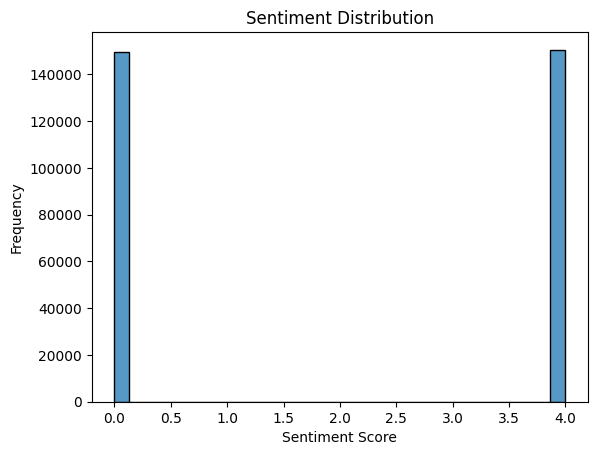

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['sentiment'], bins=30)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [9]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text', 'clean_text']
df = df[['target', 'clean_text']]
df['target'] = df['target'].map({0: 0, 4: 1})  # 0: negative, 1: positive

In [10]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
#df_train, df_test = train_test_split(df, random_state=42)
#print("TRAIN size:", len(df_train))
#print("TEST size:", len(df_test))

TRAIN size: 225000
TEST size: 75000


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding
import numpy as np

# 多头注意力机制
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(output)

# 前馈网络
class FeedForward(Layer):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = Dense(d_ff, activation='relu')
        self.linear2 = Dense(d_model)

    def call(self, x):
        return self.linear2(self.linear1(x))

# Add & Norm 层
class AddNormalization(Layer):
    def __init__(self):
        super(AddNormalization, self).__init__()
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, x, sublayer_output):
        return self.layer_norm(x + sublayer_output)

# 编码器层
class EncoderLayer(Layer):
    def __init__(self, num_heads, d_model, d_ff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.ffn = FeedForward(d_model, d_ff)
        self.add_norm1 = AddNormalization()
        self.add_norm2 = AddNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add_norm1(x, attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.add_norm2(out1, ffn_output)

# 编码器
class Encoder(Layer):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(num_heads, d_model, d_ff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 偶数索引
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 奇数索引
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        return pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        return self.dropout(x, training=training)

# 示例：使用编码器
if __name__ == "__main__":
    sample_encoder = Encoder(num_layers=2, num_heads=4, d_model=128, d_ff=512, input_vocab_size=10000, maximum_position_encoding=100)
    sample_input = tf.random.uniform((64, 50))  # 假设 batch_size=64，序列长度=50
    sample_output = sample_encoder(sample_input, training=True, mask=None)
    print(sample_output.shape)  # 输出形状应为 (64, 50, 128)


(64, 50, 128)


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['target'], test_size=0.2, random_state=42)

# 创建词汇表
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 填充序列
max_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [14]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding):
        super(TransformerModel, self).__init__()
        self.encoder = Encoder(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()  # 使用全局平均池化
        self.dense = Dense(2, activation='softmax')  # 输出层，2个类

    def create_padding_mask(self, seq):
        mask = tf.cast(tf.equal(seq, 0), tf.float32)  # 假设填充的值为0
        return mask[:, tf.newaxis, tf.newaxis, :]  # 形状调整为 (batch_size, 1, 1, seq_len)

    def call(self, x, training=False):
        mask = self.create_padding_mask(x)  # 创建掩码
        x = self.encoder(x, training=training, mask=mask)  # 将掩码作为关键字参数传递
        x = self.pooling(x)  # 应用全局平均池化
        return self.dense(x)  # 返回最终的输出


# 创建模型实例
num_layers = 2
num_heads = 4
d_model = 128
d_ff = 512
input_vocab_size = 10000
maximum_position_encoding = max_length

model = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# 评估模型
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/5


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7115 - loss: 0.5546 - val_accuracy: 0.7679 - val_loss: 0.4879
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7825 - loss: 0.4713 - val_accuracy: 0.7844 - val_loss: 0.4780
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7890 - loss: 0.4626 - val_accuracy: 0.7639 - val_loss: 0.4899
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7921 - loss: 0.4576 - val_accuracy: 0.7504 - val_loss: 0.5157
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7934 - loss: 0.4543 - val_accuracy: 0.7831 - val_loss: 0.4813
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - accuracy: 0.7893 - loss: 0.4743
Test Accuracy: 0.7872


In [15]:
def create_model(num_layers=2, num_heads=4, d_model=128, d_ff=512):
    model = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_layers=2, num_heads=4, d_model=128, d_ff=512, epochs=10, batch_size=64):
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = create_model(self.num_layers, self.num_heads, self.d_model, self.d_ff)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Return accuracy

from scipy.stats import randint

param_dist = {
    'num_layers': randint(1, 4),
    'num_heads': randint(2, 8),
    'd_model': [64, 128, 256],
    'd_ff': [256, 512, 1024],
    'epochs': [10, 20],  # Add epochs to the parameter grid if needed
    'batch_size': [32, 64]  # Add batch size options
}

from sklearn.model_selection import RandomizedSearchCV

# Create a KerasClassifierWrapper instance
model = KerasClassifierWrapper()

# Set up the random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, n_jobs=-1)

# Fit the random search
random_search_result = random_search.fit(X_train_pad, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)




Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: 

[CV] END batch_size=32, d_ff=256, d_model=128, epochs=10, num_heads=3, num_layers=1; total time=18.0min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=32, d_ff=256, d_model=128, epochs=10, num_heads=3, num_layers=1; total time=18.2min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=7, num_layers=2; total time=21.9min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=4, num_layers=2; total time=22.3min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=7, num_layers=2; total time=22.5min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=7, num_layers=2; total time=22.6min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=4, num_layers=2; total time=22.8min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=128, epochs=20, num_heads=4, num_layers=2; total time=22.8min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=1024, d_model=64, epochs=20, num_heads=5, num_layers=1; total time=13.0min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=1024, d_model=64, epochs=20, num_heads=5, num_layers=1; total time=13.2min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=1024, d_model=64, epochs=20, num_heads=5, num_layers=1; total time=13.5min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=32, d_ff=256, d_model=128, epochs=10, num_heads=3, num_layers=1; total time=18.3min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=32, d_ff=256, d_model=64, epochs=20, num_heads=2, num_layers=1; total time=23.1min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=32, d_ff=256, d_model=64, epochs=20, num_heads=2, num_layers=1; total time=23.0min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=32, d_ff=256, d_model=64, epochs=20, num_heads=2, num_layers=1; total time=22.9min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=512, d_model=128, epochs=20, num_heads=2, num_layers=1; total time=23.5min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=64, epochs=20, num_heads=3, num_layers=3; total time=14.0min
[CV] END batch_size=64, d_ff=256, d_model=64, epochs=20, num_heads=3, num_layers=3; total time=14.3min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=512, d_model=128, epochs=20, num_heads=2, num_layers=1; total time=24.7min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=512, d_model=128, epochs=20, num_heads=2, num_layers=1; total time=24.9min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=256, d_model=64, epochs=20, num_heads=3, num_layers=3; total time=15.4min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=512, d_model=128, epochs=10, num_heads=6, num_layers=3; total time=13.9min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


[CV] END batch_size=64, d_ff=512, d_model=128, epochs=10, num_heads=6, num_layers=3; total time=14.0min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=3, num_layers=1; total time=37.9min
[CV] END batch_size=64, d_ff=512, d_model=128, epochs=10, num_heads=6, num_layers=3; total time=14.7min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=3, num_layers=1; total time=42.3min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=3, num_layers=1; total time=40.1min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=6, num_layers=2; total time=27.7min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=6, num_layers=2; total time=27.1min
[CV] END batch_size=64, d_ff=256, d_model=256, epochs=20, num_heads=6, num_layers=2; total time=16.9min


/Users/arkgrayhe/miniconda3/envs/COMP5318/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Best Parameters: {'batch_size': 32, 'd_ff': 256, 'd_model': 128, 'epochs': 10, 'num_heads': 3, 'num_layers': 1}


TypeError: cannot unpack non-iterable float object

In [19]:
# Evaluate the best model
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7882


In [24]:
import json
from sklearn.metrics import accuracy_score

best_params = random_search.best_params_
with open('best_paramslstm.json', 'w') as f:
    json.dump(best_params, f)

# 将最佳参数保存为 JSON 文件
with open('best_paramsTransformer.json', 'w') as f:
    json.dump(best_params, f)

# 打印最佳参数
print(f"Best Parameters: {best_params}")

# 使用最佳模型对测试集进行评估
model_best = random_search.best_estimator_

# 评估模型并打印结果（例如使用准确率评估）
accuracy = model_best.score(X_test_pad,y_test)
model_best=random_search.best_estimator_
model_best.save("bestTransformer.h5")


Best Parameters: {'batch_size': 32, 'd_ff': 256, 'd_model': 128, 'epochs': 10, 'num_heads': 3, 'num_layers': 1}


AttributeError: 'KerasClassifierWrapper' object has no attribute 'save'

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# 假设 history 是训练过程的返回值
plot_loss(history)
